In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from undersampler import PresumablyCorrectUndersampler
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pickle
import shap
import matplotlib.pyplot as plt
import time

In [3]:
# Data load 
data = pd.read_csv(...ProcessedData.csv")

Y = (data["ConnectionFailure"]).values
X = data.drop(columns=["ConnectionFailure"]).values

Y_df = (data["ConnectionFailure"])
X_df = data.drop(columns=["ConnectionFailure"])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

# proper name (No imbalance and volume treatment)
X_train_no = X_train_scaled
y_train_no = y_train
X_test_no = X_test_scaled
y_test_no = y_test


(205205, 225)
(205205,)
(51302, 225)
(51302,)


### Undersampling

In [4]:
# Undersampling - Random
# start time
start_time = time.time()

ru = RandomUnderSampler(random_state=42)
X_train_ru, y_train_ru = ru.fit_resample(X_train_scaled, y_train)

# end time
end_time = time.time()
undersampling_time = end_time - start_time

X_test_ru = X_test_scaled
y_test_ru = y_test

print("Undersampling Time:", undersampling_time, "seconds")

print(X_train_ru.shape)
print(y_train_ru.shape)
print(X_test_ru.shape)
print(y_test_ru.shape)

Undersampling Time: 0.030556678771972656 seconds
(3742, 225)
(3742,)
(51302, 225)
(51302,)


In [5]:
# Undersampling - PCU
# start time
start_time = time.time()

pcu = PresumablyCorrectUndersampler(n_neighbors=5, inclusion='partial', ratio=0.8)
X_train_pcu, y_train_pcu = pcu.fit_transform(X_train_scaled, y_train)

# end time
end_time = time.time()
undersampling_pcu_time = end_time - start_time

X_test_pcu = X_test_scaled
y_test_pcu = y_test

print("PCU Undersampling Time:", undersampling_pcu_time, "seconds")

print(X_train_pcu.shape)
print(y_train_pcu.shape)
print(X_test_pcu.shape)
print(y_test_pcu.shape)

PCU Undersampling Time: 25092.164821863174 seconds
(42537, 225)
(42537,)
(51302, 225)
(51302,)


In [32]:
def evaluate_model(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)


    print("Kappa Score:", kappa)
    print("F1 Score:", f1)
    print("AUC-ROC Score:", auc_roc)
    print("Confusion matrix: ", cm)


### LR

In [7]:
# Random undersampling
model_lr_ru = LogisticRegression()
model_lr_ru.fit(X_train_ru, y_train_ru)

Y_pred_ru = model_lr_ru.predict(X_test_ru)
print(evaluate_model(y_test_ru, Y_pred_ru))

# PCU
model_lr_pcu = LogisticRegression()
model_lr_pcu.fit(X_train_pcu, y_train_pcu)

Y_pred_pcu = model_lr_pcu.predict(X_test_pcu)
print(evaluate_model(y_test_pcu, Y_pred_pcu))

Cappa Score: 0.0898593178805226
F1 Score: 0.10431458219552157
AUC-ROC Score: 0.877130483739944
Confusion matrix:  [[44360  6509]
 [   51   382]]
None


Cappa Score: 0.29358879740778787
F1 Score: 0.2985074626865672
AUC-ROC Score: 0.625113926425242
Confusion matrix:  [[50675   194]
 [  323   110]]
None


In [8]:
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_search_results(grid,name):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']


    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter' + " (" + name + ")")
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()


Best Hyperparameters: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
Time elapsed for grid search: 2652.975351333618 seconds
Time elapsed for model training: 0.1297922134399414 seconds
Results on training data: 
Cappa Score: 0.3161270935273237
F1 Score: 0.3185535944898838
AUC-ROC Score: 0.5986759668753731
Confusion matrix:  [[203252     82]
 [  1501    370]]
Results on testing data: 
Cappa Score: 0.3168963640791861
F1 Score: 0.3192660550458715
AUC-ROC Score: 0.6002161645383829
Confusion matrix:  [[50844    25]
 [  346    87]]


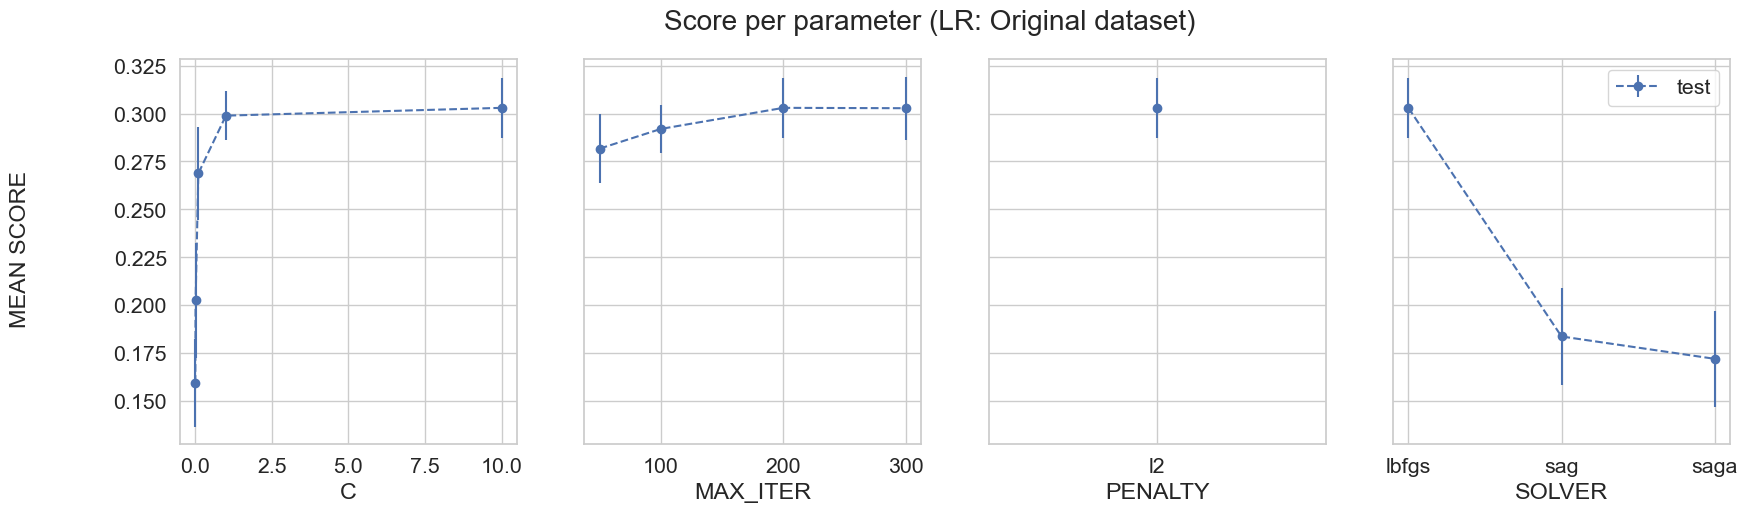

In [9]:
# HP no treatment
model_lr_hp = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': [ 'l1', 'l2'],  
    'solver': ['lbfgs','sag', 'saga'], 
    'max_iter': [50, 100, 200, 300],
}

grid_search_lr_no = GridSearchCV(model_lr_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lr_no.fit(X_train_no, y_train_no)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lr_no = grid_search_lr_no.best_estimator_
best_params_lr_no = grid_search_lr_no.best_params_


print("Best Hyperparameters:", best_params_lr_no)

Y_pred_train = best_model_lr_no.predict(X_train_no)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lr_no.predict(X_test_no)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")

print("Results on training data: ")
evaluate_model(y_train_no, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_no, Y_pred_best)
plot_search_results(grid_search_lr_no, "LR: Original dataset")

Best Hyperparameters: {'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Time elapsed for grid search: 39.81413912773132 seconds
Time elapsed for model training: 0.01209115982055664 seconds
Results on training data: 
Cappa Score: 0.7814003206841261
F1 Score: 0.8911365451157838
AUC-ROC Score: 0.890700160342063
Confusion matrix:  [[1659  212]
 [ 197 1674]]
Results on testing data: 
Cappa Score: 0.08804148595878636
F1 Score: 0.1025364274150027
AUC-ROC Score: 0.8739363897039886
Confusion matrix:  [[44270  6599]
 [   53   380]]


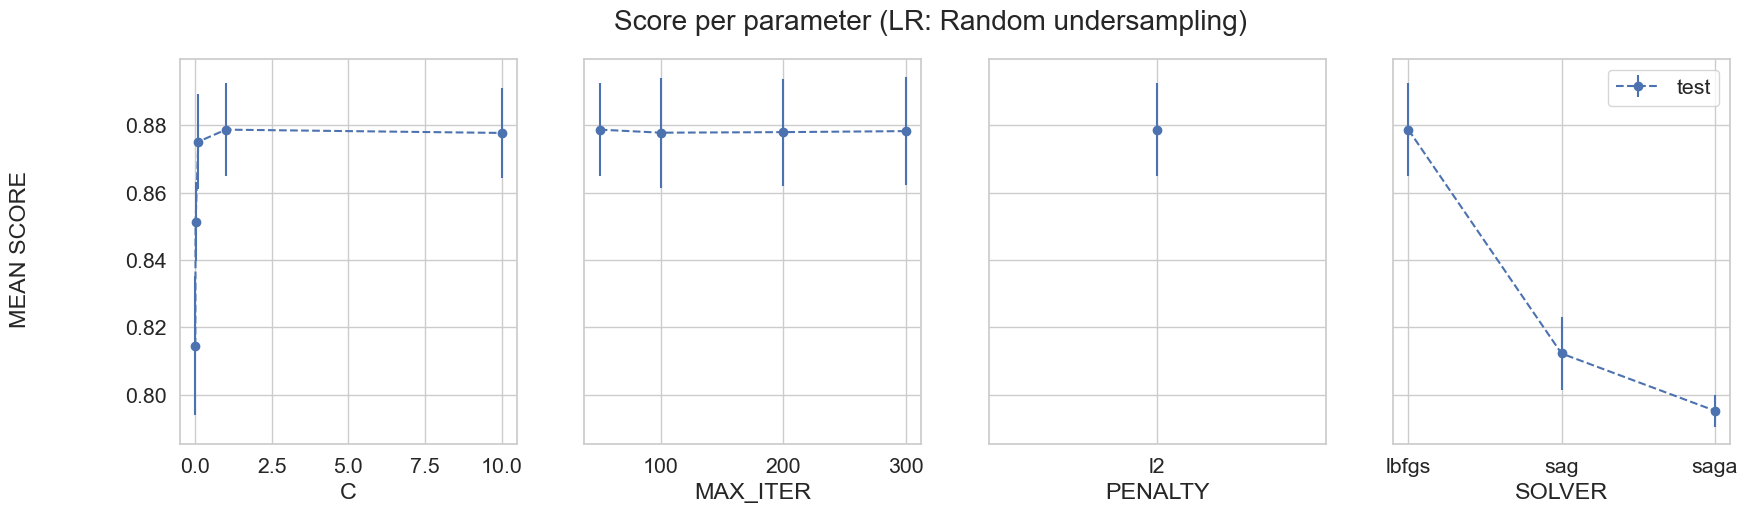

In [10]:
# HP random undersampling
model_lr_hp = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': [ 'l1', 'l2'],  
    'solver': ['lbfgs','sag', 'saga'], 
    'max_iter': [50, 100, 200, 300],
}

grid_search_lr_ru = GridSearchCV(model_lr_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lr_ru.fit(X_train_ru, y_train_ru)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lr_ru = grid_search_lr_ru.best_estimator_
best_params_lr_ru = grid_search_lr_ru.best_params_


print("Best Hyperparameters:", best_params_lr_ru)

Y_pred_train = best_model_lr_ru.predict(X_train_ru)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lr_ru.predict(X_test_ru)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")

print("Results on training data: ")
evaluate_model(y_train_ru, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_ru, Y_pred_best)
plot_search_results(grid_search_lr_ru, "LR: Random undersampling")



Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Time elapsed for grid search: 630.5487101078033 seconds
Time elapsed for model training: 0.013522148132324219 seconds
Results on training data: 
Cappa Score: 0.3877770583707528
F1 Score: 0.40248640248640244
AUC-ROC Score: 0.6361540203290257
Confusion matrix:  [[40481   185]
 [ 1353   518]]
Results on testing data: 
Cappa Score: 0.29484619361699727
F1 Score: 0.29972752043596734
AUC-ROC Score: 0.625143413932368
Confusion matrix:  [[50678   191]
 [  323   110]]


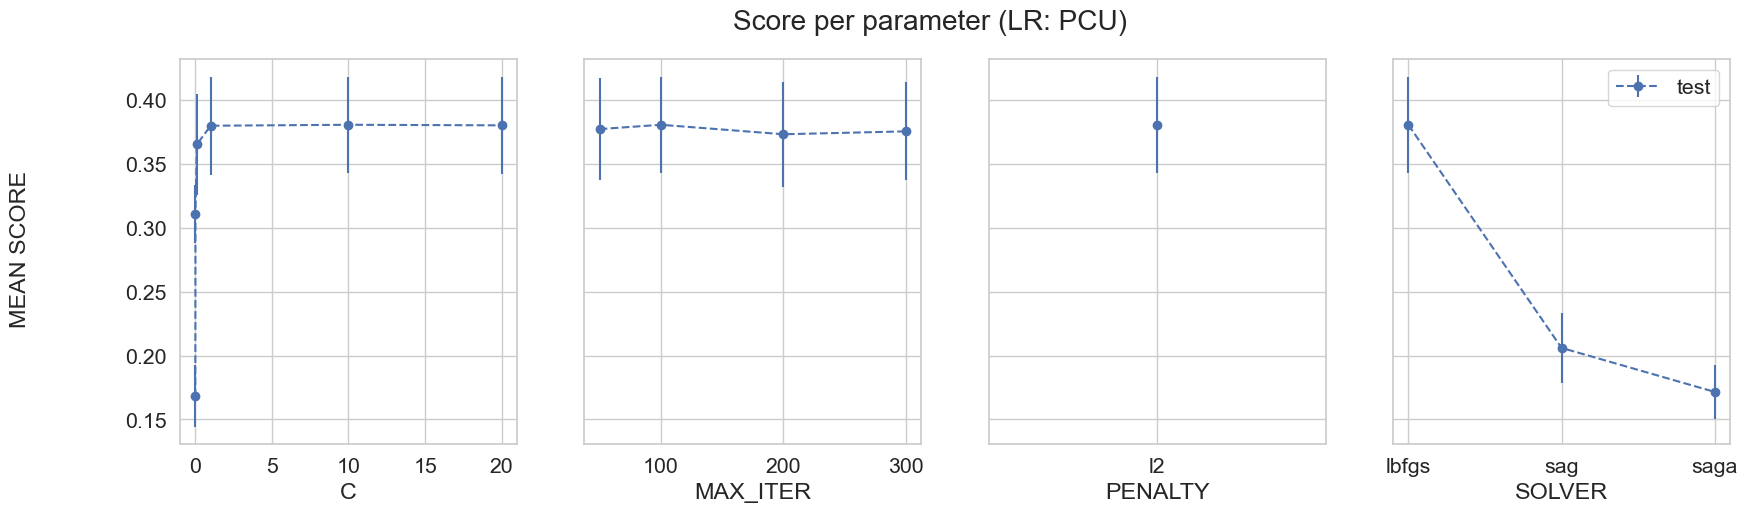

In [11]:
# HP PCU

model_lr_hp = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 20], 
    'penalty': [ 'l1', 'l2'],  
    'solver': ['lbfgs','sag', 'saga'], 
    'max_iter': [50, 100, 200, 300],
}

grid_search_lr_pcu = GridSearchCV(model_lr_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lr_pcu.fit(X_train_pcu, y_train_pcu)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lr_pcu = grid_search_lr_pcu.best_estimator_
best_params_lr_pcu = grid_search_lr_pcu.best_params_


print("Best Hyperparameters:", best_params_lr_pcu)

Y_pred_train = best_model_lr_pcu.predict(X_train_pcu)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lr_pcu.predict(X_test_pcu)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")

print("Results on training data: ")
evaluate_model(y_train_pcu, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_pcu, Y_pred_best)
plot_search_results(grid_search_lr_pcu, "LR: PCU")

### LGBM

In [12]:
# random undersampling

model_lgbm_ru = LGBMClassifier()
model_lgbm_ru.fit(X_train_ru, y_train_ru)

Y_pred_ru = model_lgbm_ru.predict(X_test_ru)
evaluate_model(y_test_ru, Y_pred_ru)

# PCU
model_lgbm_pcu = LGBMClassifier()
model_lgbm_pcu.fit(X_train_pcu, y_train_pcu)

Y_pred_pcu = model_lgbm_pcu.predict(X_test_pcu)
evaluate_model(y_test_pcu, Y_pred_pcu)

[LightGBM] [Info] Number of positive: 1871, number of negative: 1871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21620
[LightGBM] [Info] Number of data points in the train set: 3742, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Cappa Score: 0.203099309238577
F1 Score: 0.2150313152400835
AUC-ROC Score: 0.9463908494386045
Confusion matrix:  [[47882  2987]
 [   21   412]]
[LightGBM] [Info] Number of positive: 1871, number of negative: 40666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27153
[LightGBM] [Info] Number of data points in the train set: 42537, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043985 -> initscore=-3.078919
[LightGBM] [Info] Start training from score -3.078919
Cappa Score: 0.548590990484909
F1 Score: 0.5533039647577093
AUC-ROC Score: 0.8587728874925163
Confusion matrix:  [[50481   388]
 [  119   314]]


[LightGBM] [Info] Number of positive: 1871, number of negative: 203334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7434
[LightGBM] [Info] Number of data points in the train set: 205205, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009118 -> initscore=-4.688377
[LightGBM] [Info] Start training from score -4.688377
Best Hyperparameters: {'learning_rate': 0.1, 'max_bin': 70, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 35}
Time elapsed for grid search: 2484.065809726715 seconds
Time elapsed for model training: 0.19210314750671387 seconds
Results on training data: 
Cappa Score: 1.0
F1 Score: 1.0
AUC-ROC Score: 1.0
Confusion matrix:  [[203334      0]
 [     0   1871]]
Results on testing data: 
Cappa Score: 0.8000324100085365
F1 Score: 0.8015364916773368
AUC-ROC Score: 0.8610878497532742
Confusion matrix:  

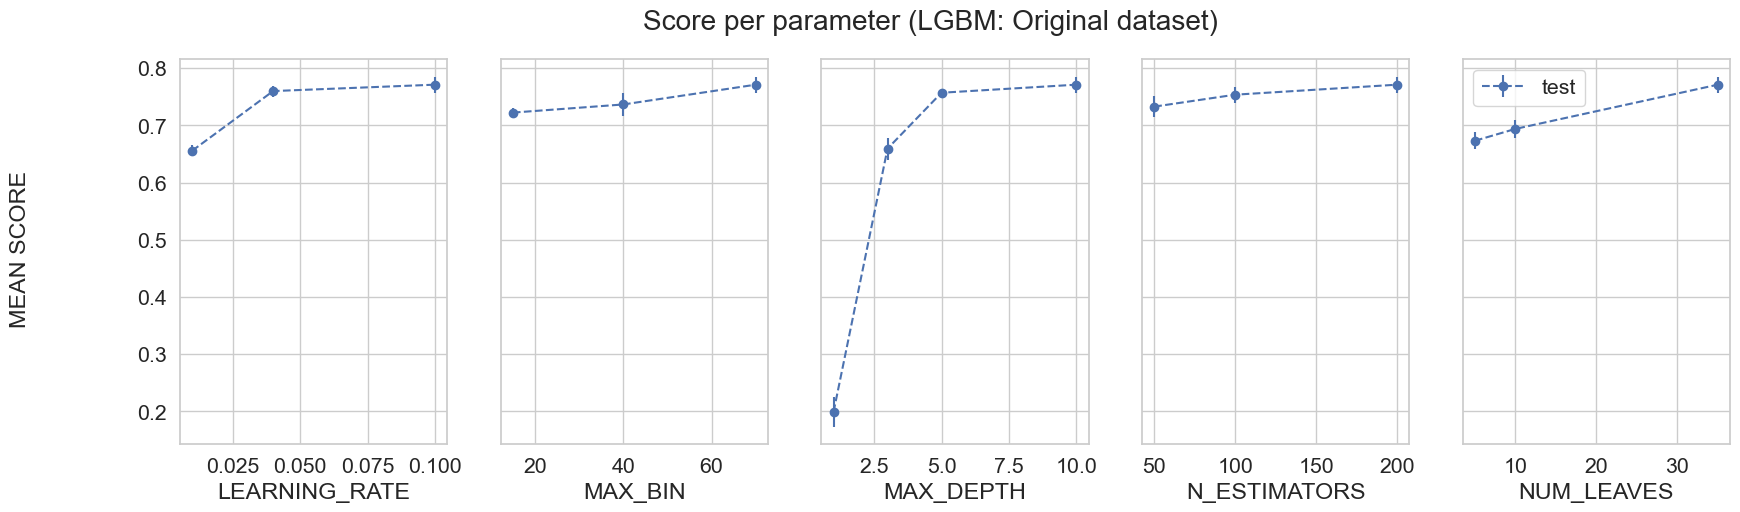

In [13]:
# HP no treatment

model_lgbm_hp = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.04, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 10],
    'num_leaves': [5, 10, 35],
    'max_bin': [15, 40, 70]
}


grid_search_lgbm_no = GridSearchCV(model_lgbm_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lgbm_no.fit(X_train_no, y_train_no)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lgbm_no = grid_search_lgbm_no.best_estimator_
best_params_lgbm_no = grid_search_lgbm_no.best_params_

print("Best Hyperparameters:", best_params_lgbm_no)

Y_pred_train = best_model_lgbm_no.predict(X_train_no)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lgbm_no.predict(X_test_no)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_no, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_no, Y_pred_best)
plot_search_results(grid_search_lgbm_no, "LGBM: Original dataset")

[LightGBM] [Info] Number of positive: 1871, number of negative: 1871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4357
[LightGBM] [Info] Number of data points in the train set: 3742, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Hyperparameters: {'learning_rate': 0.1, 'max_bin': 40, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 35}
Time elapsed for grid search: 132.22085976600647 seconds
Time elapsed for model training: 0.19605088233947754 seconds
Results on training data: 
Cappa Score: 1.0
F1 Score: 1.0
AUC-ROC Score: 1.0
Confusion matrix:  [[1871    0]
 [   0 1871]]
Results on testing data: 
Cappa Score: 0.21409890693847422
F1 Score: 0.2257797405465084
AUC-ROC Score: 0.9449514550280104
Confusion matrix:  [[48088  2781]
 [   24   409]]


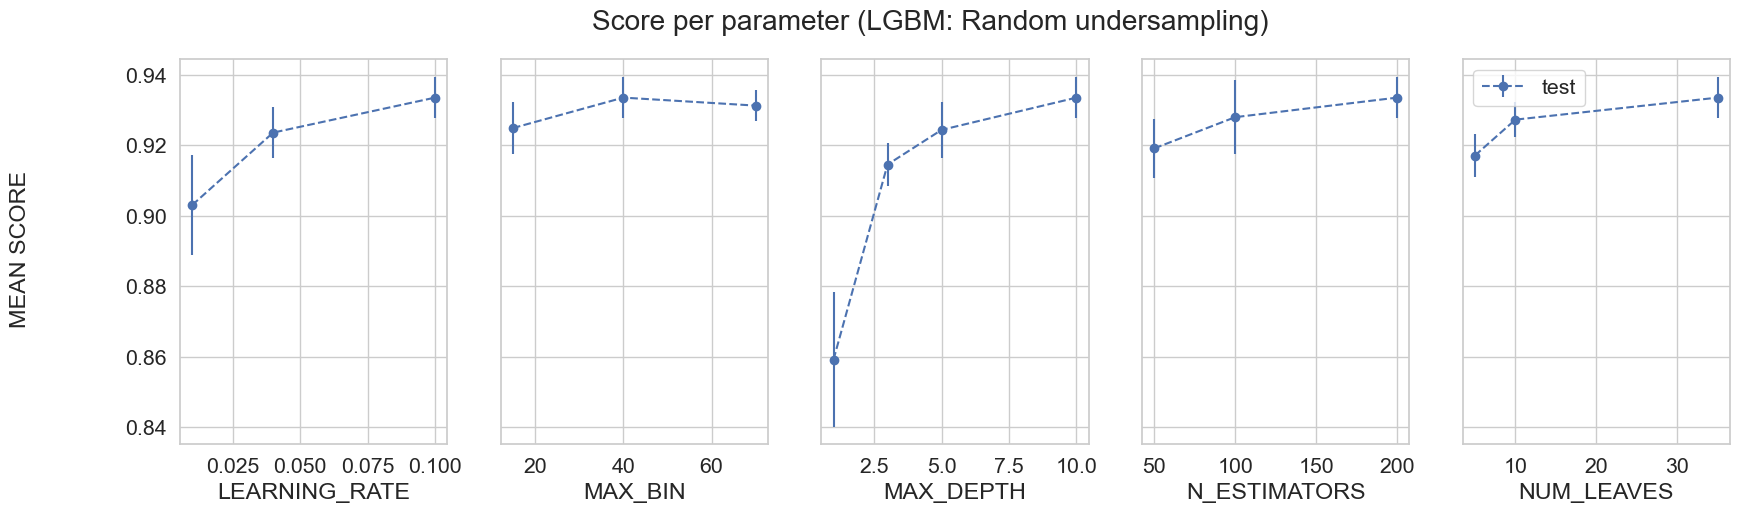

In [14]:
# HP random undersampling

model_lgbm_hp = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.04, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 10],
    'num_leaves': [5, 10, 35],
    'max_bin': [15, 40, 70]
}


grid_search_lgbm_ru = GridSearchCV(model_lgbm_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lgbm_ru.fit(X_train_ru, y_train_ru)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lgbm_ru = grid_search_lgbm_ru.best_estimator_
best_params_lgbm_ru = grid_search_lgbm_ru.best_params_

print("Best Hyperparameters:", best_params_lgbm_ru)

Y_pred_train = best_model_lgbm_ru.predict(X_train_ru)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lgbm_ru.predict(X_test_ru)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_ru, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_ru, Y_pred_best)
plot_search_results(grid_search_lgbm_ru, "LGBM: Random undersampling")


[LightGBM] [Info] Number of positive: 1871, number of negative: 40666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4810
[LightGBM] [Info] Number of data points in the train set: 42537, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043985 -> initscore=-3.078919
[LightGBM] [Info] Start training from score -3.078919
Best Hyperparameters: {'learning_rate': 0.1, 'max_bin': 40, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 35}
Time elapsed for grid search: 648.8239510059357 seconds
Time elapsed for model training: 0.18060588836669922 seconds
Results on training data: 
Cappa Score: 1.0
F1 Score: 1.0
AUC-ROC Score: 1.0
Confusion matrix:  [[40666     0]
 [    0  1871]]
Results on testing data: 
Cappa Score: 0.5124057274428415
F1 Score: 0.5178147268408552
AUC-ROC Score: 0.8726540803967916
Confusion matrix:  [[5036

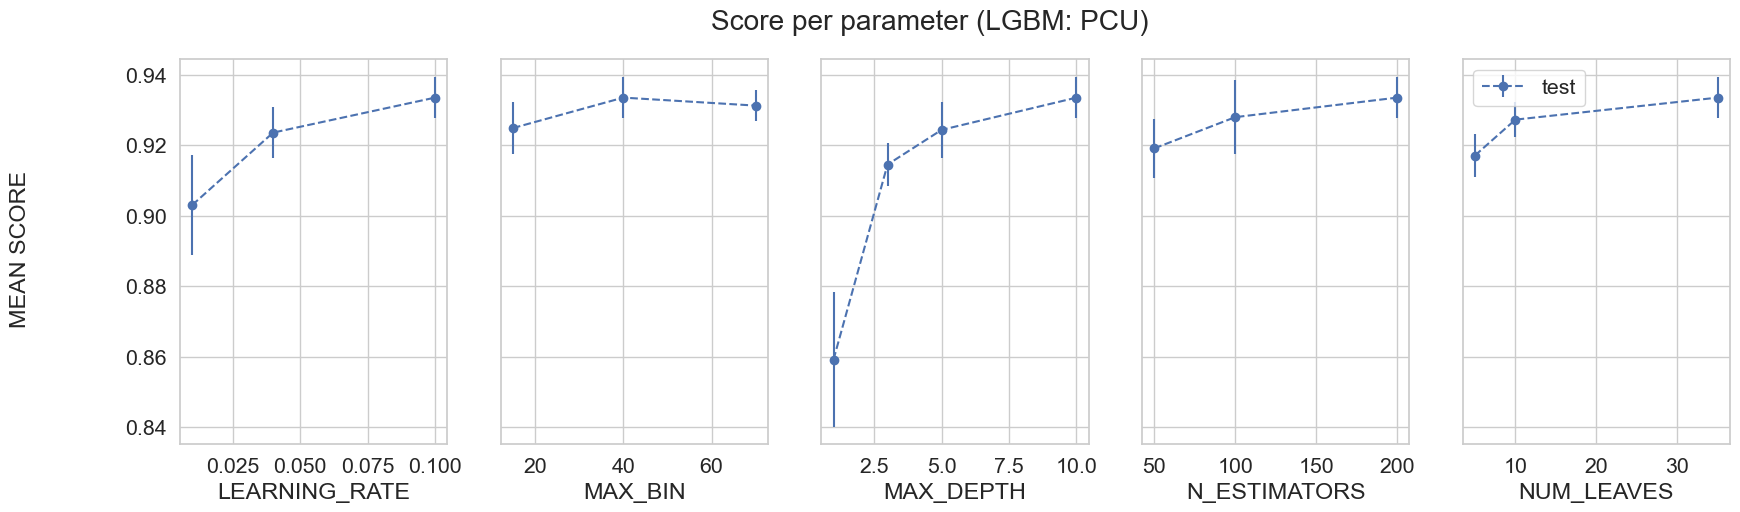

In [15]:
# HP PCU

model_lgbm_hp = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.04, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 10],
    'num_leaves': [5, 10, 35],
    'max_bin': [15, 40, 70]
}


grid_search_lgbm_pcu = GridSearchCV(model_lgbm_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_lgbm_pcu.fit(X_train_pcu, y_train_pcu)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_lgbm_pcu = grid_search_lgbm_pcu.best_estimator_
best_params_lgbm_pcu = grid_search_lgbm_pcu.best_params_


print("Best Hyperparameters:", best_params_lgbm_pcu)

Y_pred_train = best_model_lgbm_pcu.predict(X_train_pcu)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_lgbm_pcu.predict(X_test_pcu)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")

print("Results on training data: ")
evaluate_model(y_train_pcu, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_pcu, Y_pred_best)
plot_search_results(grid_search_lgbm_ru, "LGBM: PCU")

### Random forests

In [16]:
from sklearn.ensemble import RandomForestClassifier

# random undersampling
model_rf_ru = RandomForestClassifier()
model_rf_ru.fit(X_train_ru, y_train_ru)

Y_pred_ru = model_rf_ru.predict(X_test_ru)
evaluate_model(y_test_ru, Y_pred_ru)

# PCU
model_rf_pcu = RandomForestClassifier()
model_rf_pcu.fit(X_train_pcu, y_train_pcu)

Y_pred_pcu = model_rf_pcu.predict(X_test_pcu)
evaluate_model(y_test_pcu, Y_pred_pcu)

Cappa Score: 0.1884104761318237
F1 Score: 0.20060790273556234
AUC-ROC Score: 0.9266176485476869
Confusion matrix:  [[47750  3119]
 [   37   396]]
Cappa Score: 0.7079841264093031
F1 Score: 0.7103694874851012
AUC-ROC Score: 0.8430493042469228
Confusion matrix:  [[50761   108]
 [  135   298]]


Best Hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Time elapsed for grid search: 12357.821213960648 seconds
Time elapsed for model training: 0.2608475685119629 seconds
Results on training data: 
Cappa Score: 0.8296999983946539
F1 Score: 0.830990315526398
AUC-ROC Score: 0.8554249064671299
Confusion matrix:  [[203334      0]
 [   541   1330]]
Results on testing data: 
Cappa Score: 0.7383150947285072
F1 Score: 0.74
AUC-ROC Score: 0.7989975791187953
Confusion matrix:  [[50861     8]
 [  174   259]]


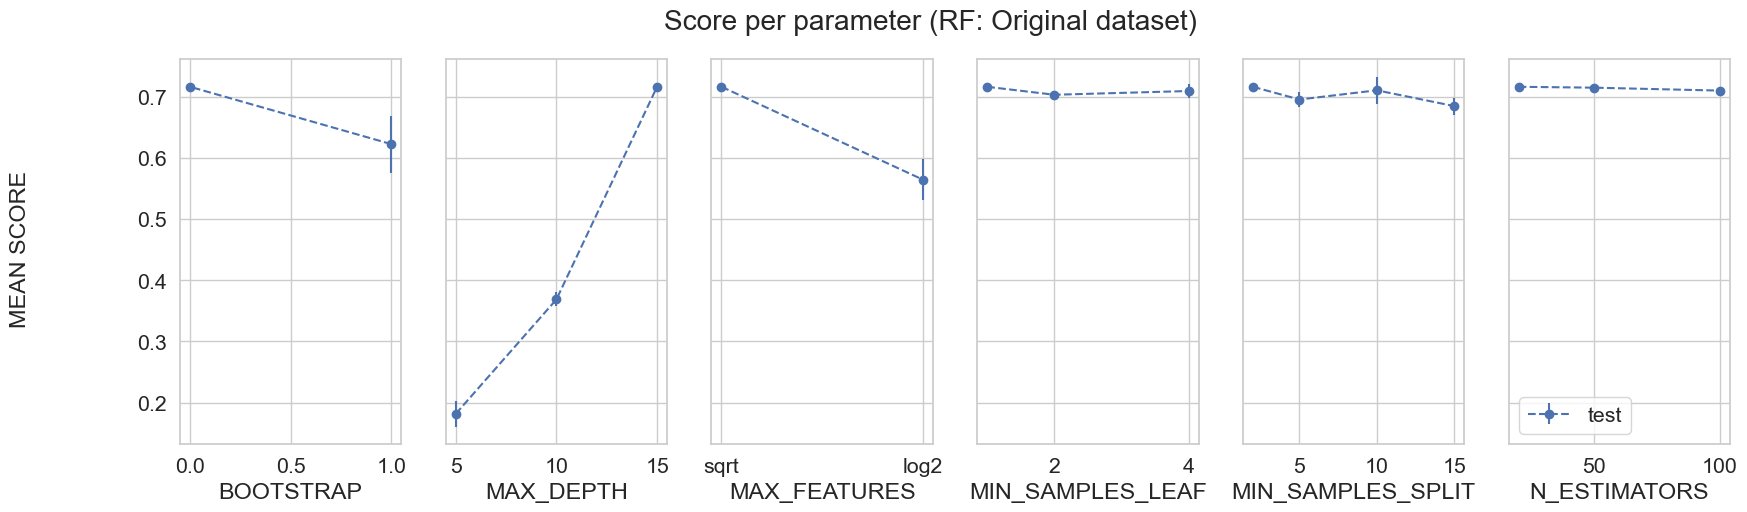

In [17]:
# HP no treatment

model_rf_hp = RandomForestClassifier()

param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search_rf_no = GridSearchCV(model_rf_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_rf_no.fit(X_train_no, y_train_no)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_rf_no = grid_search_rf_no.best_estimator_
best_params_rf_no = grid_search_rf_no.best_params_


print("Best Hyperparameters:", best_params_rf_no)

Y_pred_train = best_model_rf_no.predict(X_train_no)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_rf_no.predict(X_test_no)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_no, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_no, Y_pred_best)
plot_search_results(grid_search_rf_no, "RF: Original dataset")

Best Hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Time elapsed for grid search: 215.54057478904724 seconds
Time elapsed for model training: 0.35300135612487793 seconds
Results on training data: 
Cappa Score: 0.9957242116515232
F1 Score: 0.9978575254418853
AUC-ROC Score: 0.9978621058257616
Confusion matrix:  [[1871    0]
 [   8 1863]]
Results on testing data: 
Cappa Score: 0.2052824024468004
F1 Score: 0.21710526315789472
AUC-ROC Score: 0.9295663992603017
Confusion matrix:  [[48050  2819]
 [   37   396]]


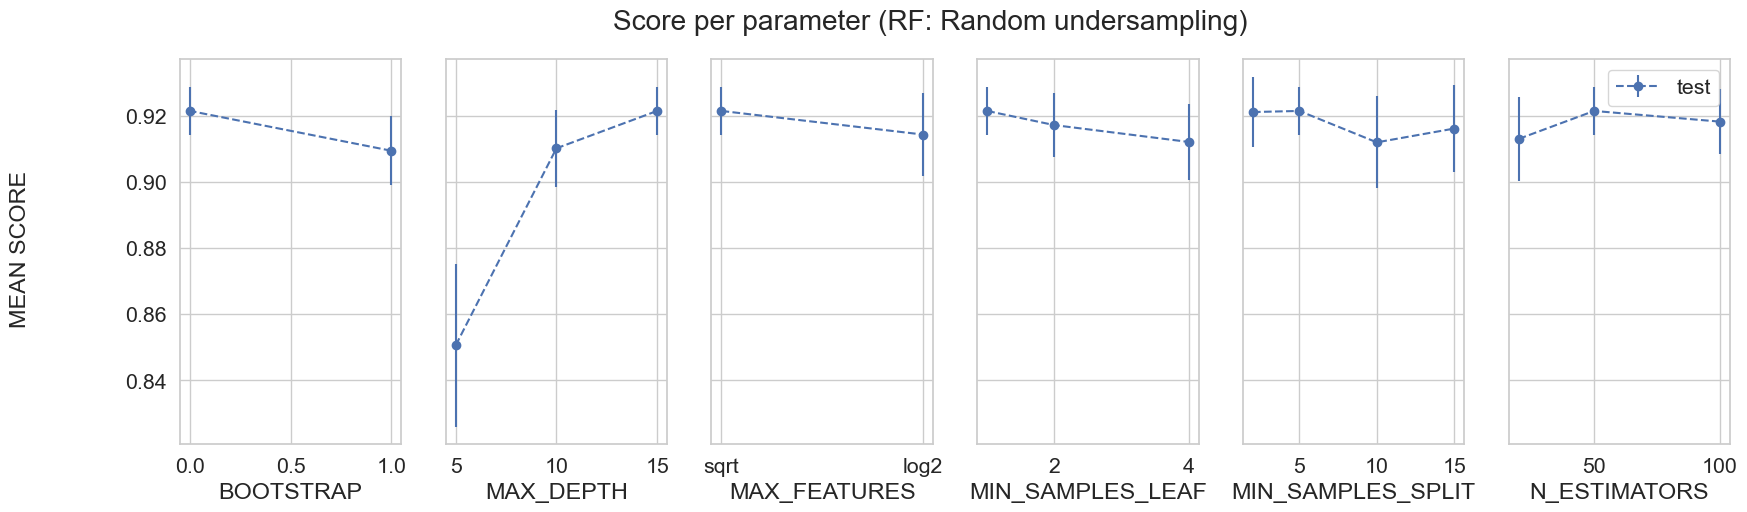

In [18]:
# HP random 

model_rf_hp = RandomForestClassifier()

param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search_rf_ru = GridSearchCV(model_rf_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_rf_ru.fit(X_train_ru, y_train_ru)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_rf_ru = grid_search_rf_ru.best_estimator_
best_params_rf_ru = grid_search_rf_ru.best_params_


print("Best Hyperparameters:", best_params_rf_ru)

Y_pred_train = best_model_rf_ru.predict(X_train_ru)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_rf_ru.predict(X_test_ru)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_ru, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_ru, Y_pred_best)
plot_search_results(grid_search_rf_ru, "RF: Random undersampling")

Best Hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Time elapsed for grid search: 3415.039464235306 seconds
Time elapsed for model training: 0.6793992519378662 seconds
Results on training data: 
Cappa Score: 0.9244023251200431
F1 Score: 0.9274863857838922
AUC-ROC Score: 0.9323890967397114
Confusion matrix:  [[40666     0]
 [  253  1618]]
Results on testing data: 
Cappa Score: 0.7266178937923184
F1 Score: 0.728813559322034
AUC-ROC Score: 0.846670774184852
Confusion matrix:  [[50777    92]
 [  132   301]]


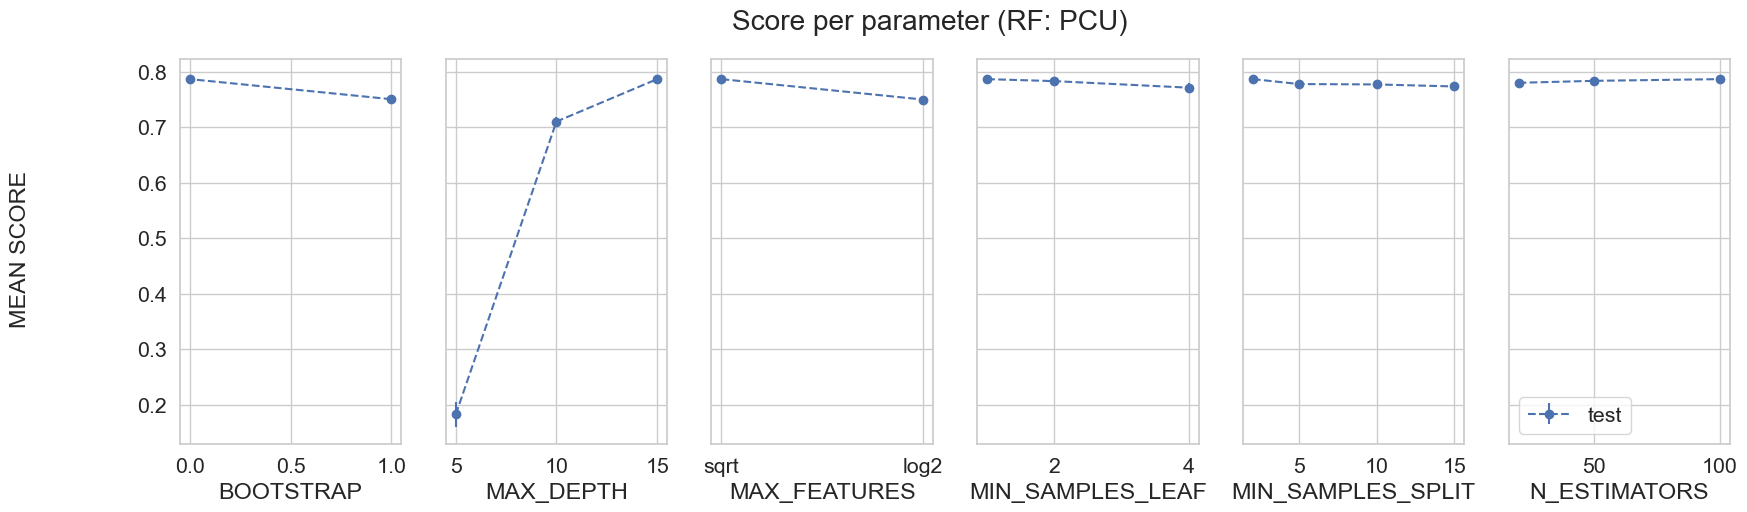

In [19]:
# HP PCU

model_rf_hp = RandomForestClassifier()

param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search_rf_pcu = GridSearchCV(model_rf_hp, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_rf_pcu.fit(X_train_pcu, y_train_pcu)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_rf_pcu = grid_search_rf_pcu.best_estimator_
best_params_rf_pcu = grid_search_rf_pcu.best_params_


print("Best Hyperparameters:", best_params_rf_pcu)

Y_pred_train = best_model_rf_pcu.predict(X_train_pcu)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_rf_pcu.predict(X_test_pcu)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")

print("Results on training data: ")
evaluate_model(y_train_pcu, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_pcu, Y_pred_best)
plot_search_results(grid_search_rf_pcu, "RF: PCU")

### SVC

In [20]:
# random undersampling
model_svc_ru = SVC()
model_svc_ru.fit(X_train_ru, y_train_ru)

Y_pred_ru = model_svc_ru.predict(X_test_ru)
evaluate_model(y_test_ru, Y_pred_ru)

# PCU
model_svc_pcu = SVC()
model_svc_pcu.fit(X_train_pcu, y_train_pcu)

Y_pred_pcu = model_svc_pcu.predict(X_test_pcu)
evaluate_model(y_test_pcu, Y_pred_pcu)

Cappa Score: 0.10007339770261736
F1 Score: 0.1142857142857143
AUC-ROC Score: 0.8853964290015965
Confusion matrix:  [[44966  5903]
 [   49   384]]
Cappa Score: 0.38415850384111594
F1 Score: 0.38664323374340953
AUC-ROC Score: 0.6267652268243062
Confusion matrix:  [[50843    26]
 [  323   110]]


Best Hyperparameters: {'C': 10, 'coef0': 0, 'kernel': 'rbf', 'max_iter': 700}
Time elapsed for grid search: 5111.977408409119 seconds
Time elapsed for model training: 7.461343288421631 seconds
Results on training data: 
Cappa Score: 0.2128564304249536
F1 Score: 0.22318753744757336
AUC-ROC Score: 0.6891078211516006
Confusion matrix:  [[199274   4060]
 [  1126    745]]
Results on testing data: 
Cappa Score: 0.18511248446148232
F1 Score: 0.19521178637200734
AUC-ROC Score: 0.6734099230659817
Confusion matrix:  [[49832  1037]
 [  274   159]]


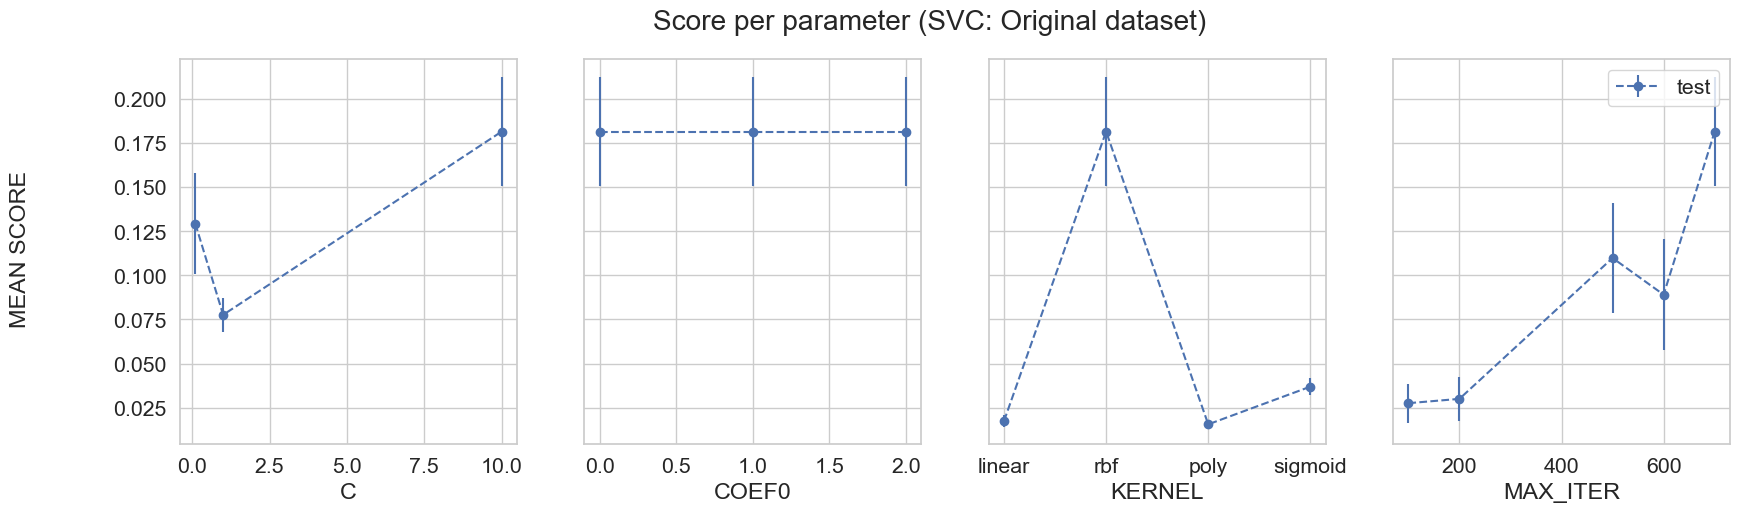

In [21]:
# HP no treatment
model_svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'coef0': [0, 1, 2],
    'max_iter': [100, 200, 500, 600, 700],
}

grid_search_svc_no = GridSearchCV(model_svc, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_svc_no.fit(X_train_no, y_train_no)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_svc_no = grid_search_svc_no.best_estimator_
best_params_svc_no = grid_search_svc_no.best_params_


print("Best Hyperparameters:", best_params_svc_no)

Y_pred_train = best_model_svc_no.predict(X_train_no)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_svc_no.predict(X_test_no)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_no, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_no, Y_pred_best)
plot_search_results(grid_search_svc_no, "SVC: Original dataset")

Best Hyperparameters: {'C': 10, 'coef0': 0, 'kernel': 'rbf', 'max_iter': 500}
Time elapsed for grid search: 85.39432644844055 seconds
Time elapsed for model training: 5.590309381484985 seconds
Results on training data: 
Cappa Score: 0.8941742383752004
F1 Score: 0.9470021413276232
AUC-ROC Score: 0.9470871191876002
Confusion matrix:  [[1775   96]
 [ 102 1769]]
Results on testing data: 
Cappa Score: 0.12258301682492634
F1 Score: 0.13628502248356972
AUC-ROC Score: 0.9062618253643138
Confusion matrix:  [[45914  4955]
 [   39   394]]


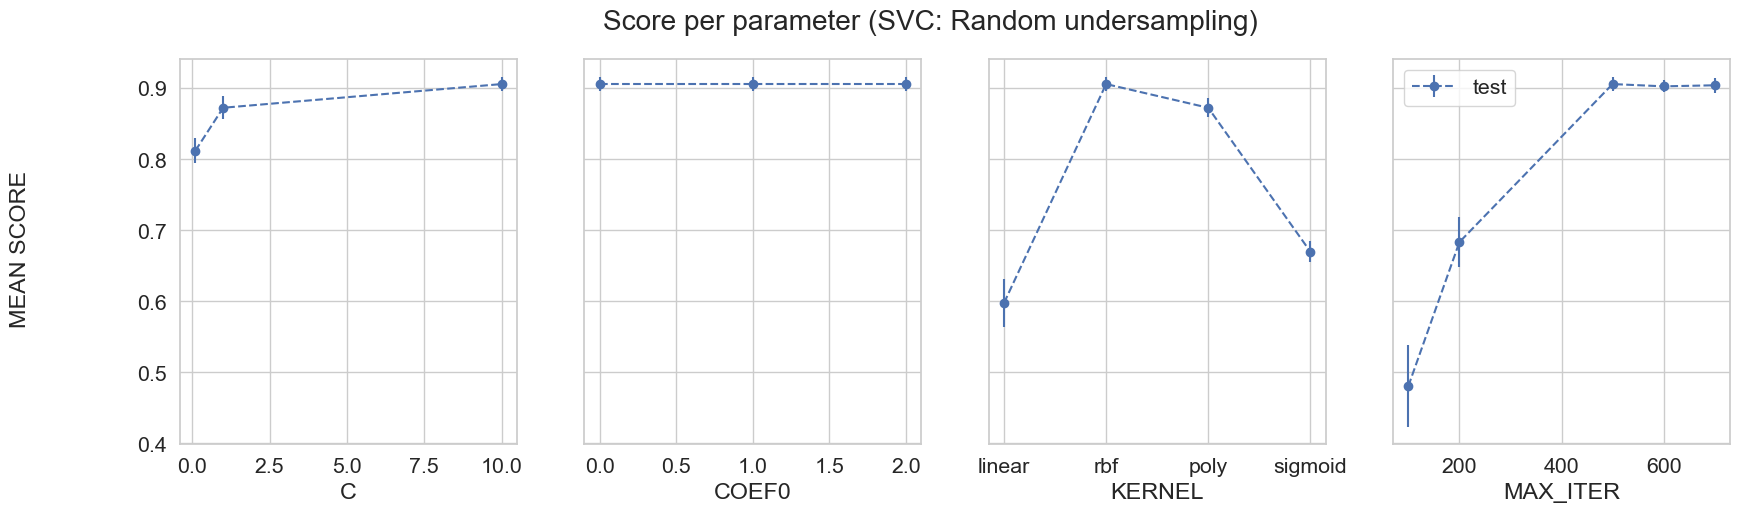

In [22]:
# HP random undersampling
model_svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'coef0': [0, 1, 2],
    'max_iter': [100, 200, 500, 600, 700],
}

grid_search_svc_ru = GridSearchCV(model_svc, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_svc_ru.fit(X_train_ru, y_train_ru)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_svc_ru = grid_search_svc_ru.best_estimator_
best_params_svc_ru = grid_search_svc_ru.best_params_


print("Best Hyperparameters:", best_params_svc_ru)

Y_pred_train = best_model_svc_ru.predict(X_train_ru)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_svc_ru.predict(X_test_ru)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_ru, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_ru, Y_pred_best)
plot_search_results(grid_search_svc_ru, "SVC: Random undersampling")

Best Hyperparameters: {'C': 10, 'coef0': 0, 'kernel': 'rbf', 'max_iter': 700}
Time elapsed for grid search: 1022.8107535839081 seconds
Time elapsed for model training: 7.831595420837402 seconds
Results on training data: 
Cappa Score: 0.3870602154598404
F1 Score: 0.41602770220133556
AUC-ROC Score: 0.7083811026893932
Confusion matrix:  [[39335  1331]
 [ 1030   841]]
Results on testing data: 
Cappa Score: 0.10439392204451314
F1 Score: 0.1171875
AUC-ROC Score: 0.6687300808938342
Confusion matrix:  [[48651  2218]
 [  268   165]]


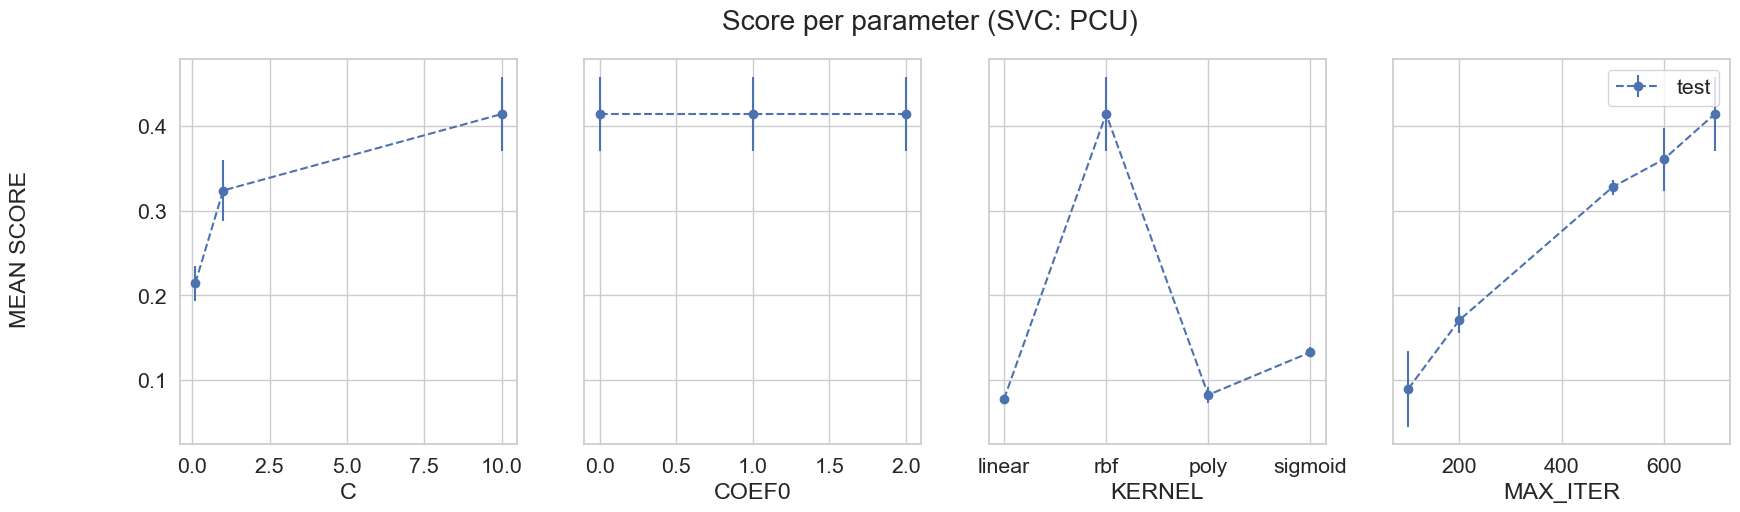

In [23]:
#HP PCU
model_svc = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'coef0': [0, 1, 2],
    'max_iter': [100, 200, 500, 600, 700],
}

grid_search_svc_pcu = GridSearchCV(model_svc, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# start time
grid_search_start_time = time.time()
grid_search_svc_pcu.fit(X_train_pcu, y_train_pcu)
# end time
grid_search_end_time = time.time()
grid_search_elapsed_time = grid_search_end_time - grid_search_start_time

best_model_svc_pcu = grid_search_svc_pcu.best_estimator_
best_params_svc_pcu = grid_search_svc_pcu.best_params_


print("Best Hyperparameters:", best_params_svc_pcu)

Y_pred_train = best_model_svc_pcu.predict(X_train_pcu)

# start time
model_train_start_time = time.time()
Y_pred_best = best_model_svc_pcu.predict(X_test_pcu)
# end time
model_train_end_time = time.time()
model_train_elapsed_time = model_train_end_time - model_train_start_time

print(f"Time elapsed for grid search: {grid_search_elapsed_time} seconds")
print(f"Time elapsed for model training: {model_train_elapsed_time} seconds")


print("Results on training data: ")
evaluate_model(y_train_pcu, Y_pred_train)
print("Results on testing data: ")
evaluate_model(y_test_pcu, Y_pred_best)
plot_search_results(grid_search_svc_pcu, "SVC: PCU")

### Feature importance rankings

### SHAP

In [25]:
K = 1
back_data_summary = shap.sample(X_train_pcu, K)
explainer = shap.TreeExplainer(best_model_rf_pcu, back_data_summary)
shap_values = explainer.shap_values(X_train_pcu)


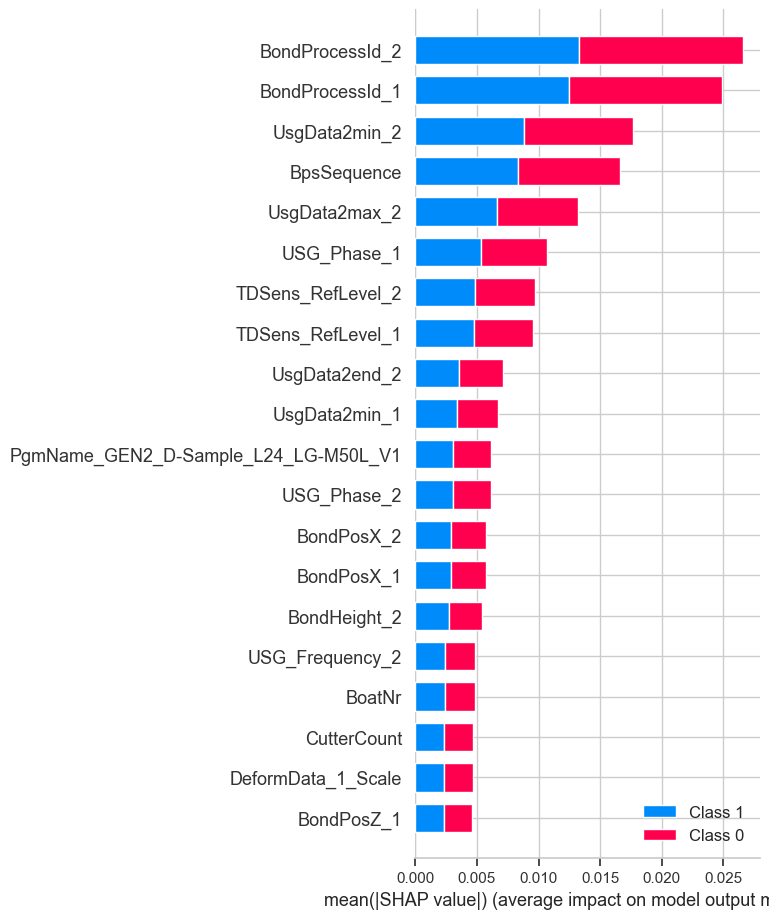

In [26]:
shap.summary_plot(shap_values, X_train_pcu, feature_names=X_df.columns)


In [27]:
# SHAP feature relevance scores
feature_importance_scores = np.abs(shap_values).mean(axis=0)
feature_importance_scores_flat = feature_importance_scores.flatten()
feature_importance = pd.DataFrame(list(zip(X_df.columns, feature_importance_scores_flat)), columns=['col_name', 'feature_importance_vals'])

# Assuming feature importance
feature_importance['abs_mean_shap'] = feature_importance['feature_importance_vals'].apply(lambda x: np.max(np.abs(x)))
feature_importance.sort_values(by=['abs_mean_shap'], ascending=False, inplace=True) # sort
feature_importance.drop(columns=['abs_mean_shap'], inplace=True) # and drop

# Create dictionary
shap_feature_importance_dict = feature_importance.set_index('col_name')['feature_importance_vals'].to_dict()
print(shap_feature_importance_dict)


{'BondProcessId_1': 0.14883182299956843, 'BondProcessId_2': 0.11966313663526762, 'BoatNr': 0.058034528701682575, 'BondPosZ_2': 0.05421920700246119, 'BondHeight_2': 0.05064867491455516, 'MachineID_WB-3 Timothy 62-600504': 0.04508363938657567, 'WireGuideCount': 0.036839836539002135, 'CutterCount': 0.03434867713076528, 'LoopCount': 0.03283020513072188, 'WedgeCount': 0.02768675695551792, 'CleanWedgeCount': 0.024836569500621408, 'PullDeflThresh_2': 0.024575057032052428, 'BondPosX_2': 0.024209812021581456, 'USG_Phase_1': 0.02304930040236286, 'BondPosZA_2': 0.019980303198963156, 'ModuleNr': 0.019941214617574587, 'BondPosX_1': 0.018545493036981497, 'TDSens_RefLevel_2': 0.018074389765388332, 'BpsSequence': 0.01663494161584822, 'BondPosZ_1': 0.016301359399221838, 'T_Interwire': 0.016142851411132142, 'PullTStopPt_2': 0.014546286649419926, 'BondPosZA_1': 0.01172908043008647, 'PullForce_1': 0.010151411639526486, 'SuspensionDeflection_2': 0.009379473209264688, 'TDSens_RefLevel_1': 0.0092377142218538

In [28]:
from sklearn.inspection import permutation_importance

y_pred_original = best_model_rf_pcu.predict(X_test_pcu)
original_accuracy = f1_score(y_test_pcu, y_pred_original)
print("Original F1:", original_accuracy)

# Perform permutation feature importance
perm_importance = permutation_importance(best_model_rf_pcu, X_test_pcu, y_test_pcu, n_repeats=30, random_state=42, n_jobs=-1)

# Get feature importances and indices
feature_importances = perm_importance.importances_mean
feature_indices = np.argsort(feature_importances)[::-1]

# Create a dictionary to store permutation importance scores
perm_importance_dict = dict(zip(X_df.columns, feature_importances))

# Display the feature importance scores
print("Permutation Feature Importances:")
for i, idx in enumerate(feature_indices):
    print(f"{X_df.columns[idx]}: {feature_importances[idx]}")


Original F1: 0.728813559322034
Permutation Feature Importances:
BpsSequence: 0.00020661962496590914
USG_VibHornPP_1: 0.00011890374644264826
ModuleNr: 0.00011370576845608124
USG_VibHornPP_2: 9.746208724806805e-05
BondPosX_2: 9.031486751654623e-05
USG_ElectricPower_2: 8.706613127495988e-05
USG_ElectricPower_1: 8.51168895299829e-05
CleanWedgeCount: 8.51168895299792e-05
PgmName_GEN2_D-Sample_L24_LG-M50L_V1: 7.861941704679169e-05
DeformationT90T_2: 7.472093355685994e-05
USG_Phase_2: 7.277169181190146e-05
WireGuideCount: 6.23757358387785e-05
UsgData1end_2: 5.9776746845504235e-05
DeformationT20T_2: 5.977674684549313e-05
USG_Phase_1: 5.7827505100534654e-05
DeformationT50T_2: 5.7177757852222565e-05
DeformationReserve_2: 5.7177757852222565e-05
LoopHeightPercent: 5.6528010603903076e-05
BondPosX_1: 5.652801060389197e-05
PullMaxValue_2: 4.808129637573488e-05
PullTStartPt_1: 4.8081296375723784e-05
USG_CurrentPP_2: 4.61320546307579e-05
USG_VoltagePP_2: 4.5482307382438414e-05
DeformationT100T_1: 4.223

### Pixel flipping experiment

In [29]:
# One-hot encoded features
def identify_one_hot_encoded_columns(df):
    one_hot_columns = []
    
    for col in df.columns:
        unique_values = df[col].unique()
        
        if len(unique_values) == 2 and set(unique_values) == {0, 1}:
            one_hot_columns.append(col)
    
    return one_hot_columns

one_hot_columns = identify_one_hot_encoded_columns(X_df)

# Pixel flipping (marginalizing most important features one by one)
num_features = len(shap_feature_importance_dict)
F1_scores_RF = []
X_test_filtered = X_test_pcu.copy()

# Initial kappa score when no feature is marginalized
initial_pred = best_model_rf_pcu.predict(X_test_pcu)
initial_f1 = f1_score(y_test_pcu, initial_pred)
F1_scores_RF.append(initial_f1)
print(f"Iteration 0: No Feature Marginalized, F1: {initial_f1}")

for i in range(num_features):
    # Most important feature
    feature_to_marginalize = list(shap_feature_importance_dict.keys())[i]
    
    if feature_to_marginalize in one_hot_columns:
        X_test_filtered[:, X_df.columns == feature_to_marginalize] = 1 # one-hot encoded features set to 
    else:
        feature_index_to_marginalize = X_df.columns.get_loc(feature_to_marginalize)
        mean_value = np.mean(X_test_filtered[:, feature_index_to_marginalize])
        X_test_filtered[:, feature_index_to_marginalize] = mean_value
    
    # best model prediction
    pred = best_model_rf_pcu.predict(X_test_filtered)
    F1 = f1_score(y_test_pcu, pred)
    F1_scores_RF.append(F1)
    
    print(f"Iteration {i + 1}: Marginalized Feature: {feature_to_marginalize}, F1 score: {F1}")


Iteration 0: No Feature Marginalized, F1: 0.728813559322034
Iteration 1: Marginalized Feature: BondProcessId_1, F1 score: 0.7536231884057971
Iteration 2: Marginalized Feature: BondProcessId_2, F1 score: 0.528428093645485
Iteration 3: Marginalized Feature: BoatNr, F1 score: 0.4931506849315068
Iteration 4: Marginalized Feature: BondPosZ_2, F1 score: 0.3882783882783883
Iteration 5: Marginalized Feature: BondHeight_2, F1 score: 0.36734693877551017
Iteration 6: Marginalized Feature: MachineID_WB-3 Timothy 62-600504, F1 score: 0.3612662942271881
Iteration 7: Marginalized Feature: WireGuideCount, F1 score: 0.3465160075329567
Iteration 8: Marginalized Feature: CutterCount, F1 score: 0.2990291262135922
Iteration 9: Marginalized Feature: LoopCount, F1 score: 0.26242544731610334
Iteration 10: Marginalized Feature: WedgeCount, F1 score: 0.26242544731610334
Iteration 11: Marginalized Feature: CleanWedgeCount, F1 score: 0.26587301587301587
Iteration 12: Marginalized Feature: PullDeflThresh_2, F1 sco

In [30]:
sorted_perm_importance = dict(sorted(perm_importance_dict.items(), key=lambda x: x[1], reverse=True))
# Pixel flipping (marginalizing most important features one by one)
num_features = len(sorted_perm_importance)
F1_scores_RF_PIMP = []
X_test_filtered = X_test_pcu.copy()

# Initial kappa score when no feature is marginalized
initial_pred = best_model_rf_pcu.predict(X_test_pcu)
initial_f1 = f1_score(y_test_pcu, initial_pred)
F1_scores_RF_PIMP.append(initial_f1)
print(f"Iteration 0: No Feature Marginalized, F1: {initial_f1}")

for i in range(num_features):
    # Most important feature
    feature_to_marginalize = list(sorted_perm_importance.keys())[i]
    
    if feature_to_marginalize in one_hot_columns:
        X_test_filtered[:, X_df.columns == feature_to_marginalize] = 1 # one-hot encoded features set to 
    else:
        feature_index_to_marginalize = X_df.columns.get_loc(feature_to_marginalize)
        mean_value = np.mean(X_test_filtered[:, feature_index_to_marginalize])
        X_test_filtered[:, feature_index_to_marginalize] = mean_value
    
    # best model prediction
    pred = best_model_rf_pcu.predict(X_test_filtered)
    F1 = f1_score(y_test_pcu, pred)
    F1_scores_RF_PIMP.append(F1)
    
    print(f"Iteration {i + 1}: Marginalized Feature: {feature_to_marginalize}, F1 score: {F1}")


Iteration 0: No Feature Marginalized, F1: 0.728813559322034
Iteration 1: Marginalized Feature: BpsSequence, F1 score: 0.7042944785276074
Iteration 2: Marginalized Feature: USG_VibHornPP_1, F1 score: 0.7051597051597052
Iteration 3: Marginalized Feature: ModuleNr, F1 score: 0.6815365551425031
Iteration 4: Marginalized Feature: USG_VibHornPP_2, F1 score: 0.681592039800995
Iteration 5: Marginalized Feature: BondPosX_2, F1 score: 0.6741573033707866
Iteration 6: Marginalized Feature: USG_ElectricPower_2, F1 score: 0.6691729323308271
Iteration 7: Marginalized Feature: USG_ElectricPower_1, F1 score: 0.653113087674714
Iteration 8: Marginalized Feature: CleanWedgeCount, F1 score: 0.643765903307888
Iteration 9: Marginalized Feature: PgmName_GEN2_D-Sample_L24_LG-M50L_V1, F1 score: 0.5586924219910846
Iteration 10: Marginalized Feature: DeformationT90T_2, F1 score: 0.5552238805970149
Iteration 11: Marginalized Feature: USG_Phase_2, F1 score: 0.548238897396631
Iteration 12: Marginalized Feature: Wire

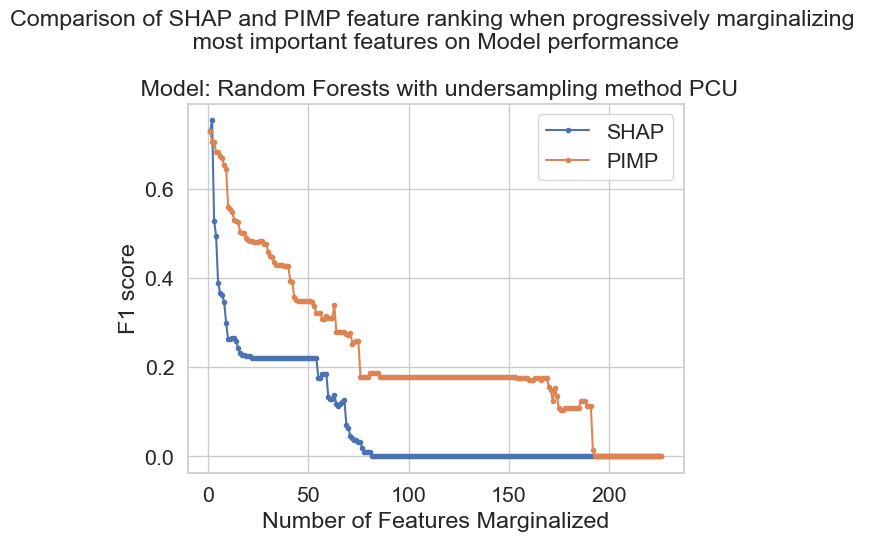

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(F1_scores_RF) + 1), F1_scores_RF, label='SHAP', marker='.')
plt.plot(range(1, len(F1_scores_RF_PIMP) + 1), F1_scores_RF_PIMP, label='PIMP', marker='.')

plt.xlabel('Number of Features Marginalized')
plt.ylabel('F1 score')
plt.title('Comparison of SHAP and PIMP feature ranking when progressively marginalizing \n most important features on Model performance \n \n Model: Random Forests with undersampling method PCU')
plt.legend(['SHAP', 'PIMP']) 
plt.show()

In [41]:
K = 1
back_data_summary = shap.sample(X_train_no, K)
explainer = shap.TreeExplainer(best_model_rf_no, back_data_summary)
shap_values = explainer.shap_values(X_train_no)


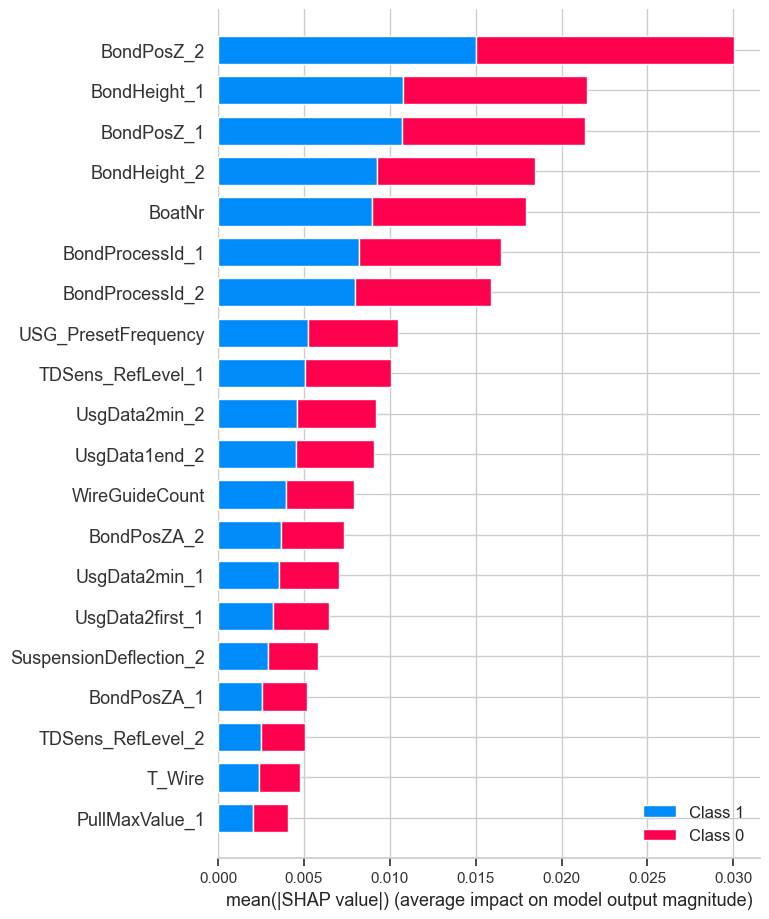

In [42]:
shap.summary_plot(shap_values, X_train_no, feature_names=X_df.columns)

In [43]:
# SHAP feature relevance scores
feature_importance_scores = np.abs(shap_values).mean(axis=0)
feature_importance_scores_flat = feature_importance_scores.flatten()
feature_importance = pd.DataFrame(list(zip(X_df.columns, feature_importance_scores_flat)), columns=['col_name', 'feature_importance_vals'])

# Assuming feature importance
feature_importance['abs_mean_shap'] = feature_importance['feature_importance_vals'].apply(lambda x: np.max(np.abs(x)))
feature_importance.sort_values(by=['abs_mean_shap'], ascending=False, inplace=True) # sort
feature_importance.drop(columns=['abs_mean_shap'], inplace=True) # and drop

# Create dictionary
shap_feature_importance_dict = feature_importance.set_index('col_name')['feature_importance_vals'].to_dict()
print(shap_feature_importance_dict)

{'BondPosZ_2': 0.01646077894838527, 'BondHeight_2': 0.013446505152387545, 'USG_PresetFrequency': 0.008327213115990162, 'BondPosZ_1': 0.006922676868271083, 'UsgData2min_1': 0.006635304220253602, 'BondProcessId_1': 0.005347328326024581, 'BondHeight_1': 0.005066031058959197, 'WireGuideCount': 0.004170031927060336, 'UsgData2min_2': 0.0038304155023070052, 'PullFinalValue_1': 0.0034862785832956433, 'TDSens_RefLevel_1': 0.0030755030311411247, 'PullMaxValue_1': 0.0029658058629138395, 'DeformationT20V_2': 0.0028571432922035456, 'UsgData2first_2': 0.0027815975481644273, 'T_Wire': 0.0026807227986864746, 'TDSens_RefLevel_2': 0.002574728683612193, 'SuspensionDeflection_2': 0.0025000000605359674, 'UsgData2first_1': 0.0025000000605359674, 'BondPosZA_1': 0.0025000000605359674, 'UsgData1end_2': 0.0024999998277053237, 'BondProcessId_2': 0.002164995376006118, 'T_Touchdown_1': 0.0016666678129695356, 'USG_ElectricPower_1': 0.0016647792654111981, 'BondPosP_1': 0.0015387874154839665, 'USG_CurrentPP_1': 0.001

In [46]:
from sklearn.inspection import permutation_importance

y_pred_original = best_model_rf_no.predict(X_test_no)
original_accuracy = f1_score(y_test_no, y_pred_original)
print("Original F1:", original_accuracy)

# Perform permutation feature importance
perm_importance = permutation_importance(best_model_rf_no, X_test_no, y_test_no, n_repeats=30, random_state=42, n_jobs=-1)

# Get feature importances and indices
feature_importances = perm_importance.importances_mean
feature_indices = np.argsort(feature_importances)[::-1]

# Create a dictionary to store permutation importance scores
perm_importance_dict = dict(zip(X_df.columns, feature_importances))

# Display the feature importance scores
print("Permutation Feature Importances:")
for i, idx in enumerate(feature_indices):
    print(f"{X_df.columns[idx]}: {feature_importances[idx]}")

Original F1: 0.74
Permutation Feature Importances:
PgmName_GEN2_D-Sample_L24_LG-M50L_V1: 0.0013176874195937752
BondProcessId_1: 0.0008316764778500814
LoopCount: 0.0004645692825490803
BondPosX_2: 0.00033721882187828236
BondHeight_1: 0.0003248736241601935
BondProcessId_2: 0.00028199030577104046
CleanWedgeCount: 0.000247553701610063
UsgData2end_2: 0.00023715774563694744
WedgeCount: 0.00022871103140876815
TDSens_RefLevel_2: 0.00021961456993228415
T_Interwire: 0.0002092186139591575
BoatNr: 0.00020012215248268092
CutterCount: 0.0001923251855028359
BondPosZ_1: 0.0001845282185229687
BondPosP_1: 0.00017478200979817264
WireGuideCount: 0.00016763479006665454
ModuleNr: 0.00016698504281833875
UsgData2max_2: 0.00016633529557001555
UsgData2min_2: 0.0001468428781204086
PullMaxValue_1: 0.00013774641664392092
TDSens_RefLevel_1: 0.0001325484386573465
End_BondForce_2: 0.00012864995516743323
PullFinalValue_2: 0.00012540121892583208
ActBondTime_2: 0.00011695450469764909
UsgData2end_1: 0.00011240627395940894

In [50]:
# One-hot encoded features
def identify_one_hot_encoded_columns(df):
    one_hot_columns = []
    
    for col in df.columns:
        unique_values = df[col].unique()
        
        if len(unique_values) == 2 and set(unique_values) == {0, 1}:
            one_hot_columns.append(col)
    
    return one_hot_columns

one_hot_columns = identify_one_hot_encoded_columns(X_df)

# Pixel flipping (marginalizing most important features one by one)
num_features = len(shap_feature_importance_dict)
F1_scores_RF = []
X_test_filtered = X_test_no.copy()

# Initial kappa score when no feature is marginalized
initial_pred = best_model_rf_no.predict(X_test_no)
initial_f1 = f1_score(y_test_no, initial_pred)
F1_scores_RF.append(initial_f1)
print(f"Iteration 0: No Feature Marginalized, F1: {initial_f1}")

for i in range(num_features):
    # Most important feature
    feature_to_marginalize = list(shap_feature_importance_dict.keys())[i]
    
    if feature_to_marginalize in one_hot_columns:
        X_test_filtered[:, X_df.columns == feature_to_marginalize] = 1 # one-hot encoded features set to 
    else:
        feature_index_to_marginalize = X_df.columns.get_loc(feature_to_marginalize)
        mean_value = np.mean(X_test_filtered[:, feature_index_to_marginalize])
        X_test_filtered[:, feature_index_to_marginalize] = mean_value
    
    # best model prediction
    pred = best_model_rf_pcu.predict(X_test_filtered)
    F1 = f1_score(y_test_pcu, pred)
    F1_scores_RF.append(F1)
    
    print(f"Iteration {i + 1}: Marginalized Feature: {feature_to_marginalize}, F1 score: {F1}")

Iteration 0: No Feature Marginalized, F1: 0.74
Iteration 1: Marginalized Feature: BondPosZ_2, F1 score: 0.7348951911220716
Iteration 2: Marginalized Feature: BondHeight_2, F1 score: 0.7333333333333333
Iteration 3: Marginalized Feature: USG_PresetFrequency, F1 score: 0.7342747111681643
Iteration 4: Marginalized Feature: BondPosZ_1, F1 score: 0.7112860892388452
Iteration 5: Marginalized Feature: UsgData2min_1, F1 score: 0.6880000000000001
Iteration 6: Marginalized Feature: BondProcessId_1, F1 score: 0.5522620904836193
Iteration 7: Marginalized Feature: BondHeight_1, F1 score: 0.5308056872037915
Iteration 8: Marginalized Feature: WireGuideCount, F1 score: 0.4933774834437086
Iteration 9: Marginalized Feature: UsgData2min_2, F1 score: 0.494195688225539
Iteration 10: Marginalized Feature: PullFinalValue_1, F1 score: 0.4908180300500834
Iteration 11: Marginalized Feature: TDSens_RefLevel_1, F1 score: 0.3823529411764706
Iteration 12: Marginalized Feature: PullMaxValue_1, F1 score: 0.38165137614

In [51]:
sorted_perm_importance = dict(sorted(perm_importance_dict.items(), key=lambda x: x[1], reverse=True))
# Pixel flipping (marginalizing most important features one by one)
num_features = len(sorted_perm_importance)
F1_scores_RF_PIMP = []
X_test_filtered = X_test_no.copy()

# Initial kappa score when no feature is marginalized
initial_pred = best_model_rf_no.predict(X_test_no)
initial_f1 = f1_score(y_test_no, initial_pred)
F1_scores_RF_PIMP.append(initial_f1)
print(f"Iteration 0: No Feature Marginalized, F1: {initial_f1}")

for i in range(num_features):
    # Most important feature
    feature_to_marginalize = list(sorted_perm_importance.keys())[i]
    
    if feature_to_marginalize in one_hot_columns:
        X_test_filtered[:, X_df.columns == feature_to_marginalize] = 1 # one-hot encoded features set to 
    else:
        feature_index_to_marginalize = X_df.columns.get_loc(feature_to_marginalize)
        mean_value = np.mean(X_test_filtered[:, feature_index_to_marginalize])
        X_test_filtered[:, feature_index_to_marginalize] = mean_value
    
    # best model prediction
    pred = best_model_rf_pcu.predict(X_test_filtered)
    F1 = f1_score(y_test_pcu, pred)
    F1_scores_RF_PIMP.append(F1)
    
    print(f"Iteration {i + 1}: Marginalized Feature: {feature_to_marginalize}, F1 score: {F1}")

Iteration 0: No Feature Marginalized, F1: 0.74
Iteration 1: Marginalized Feature: PgmName_GEN2_D-Sample_L24_LG-M50L_V1, F1 score: 0.6885245901639343
Iteration 2: Marginalized Feature: BondProcessId_1, F1 score: 0.6506746626686656
Iteration 3: Marginalized Feature: LoopCount, F1 score: 0.6047244094488189
Iteration 4: Marginalized Feature: BondPosX_2, F1 score: 0.5846645367412141
Iteration 5: Marginalized Feature: BondHeight_1, F1 score: 0.5644371941272431
Iteration 6: Marginalized Feature: BondProcessId_2, F1 score: 0.39853747714808047
Iteration 7: Marginalized Feature: CleanWedgeCount, F1 score: 0.3731343283582089
Iteration 8: Marginalized Feature: UsgData2end_2, F1 score: 0.3663551401869159
Iteration 9: Marginalized Feature: WedgeCount, F1 score: 0.3159922928709056
Iteration 10: Marginalized Feature: TDSens_RefLevel_2, F1 score: 0.2693069306930693
Iteration 11: Marginalized Feature: T_Interwire, F1 score: 0.2732673267326733
Iteration 12: Marginalized Feature: BoatNr, F1 score: 0.26984

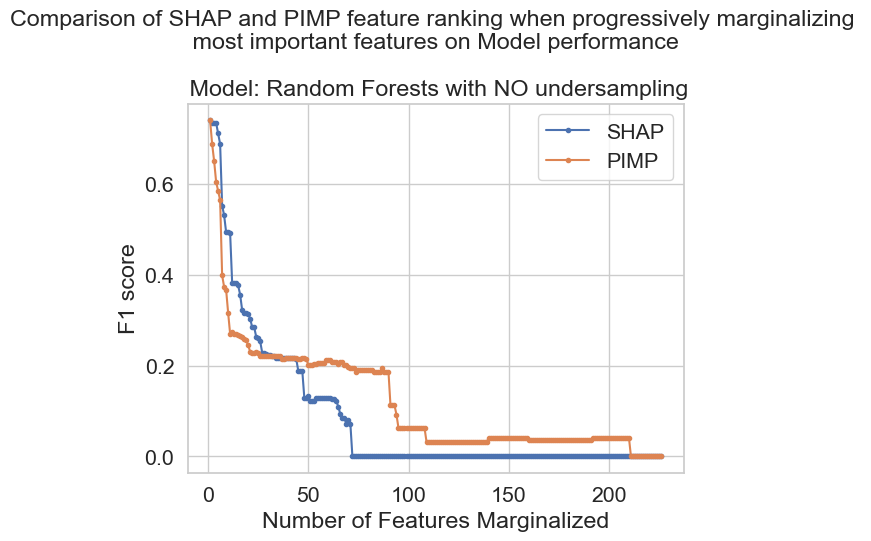

In [52]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(F1_scores_RF) + 1), F1_scores_RF, label='SHAP', marker='.')
plt.plot(range(1, len(F1_scores_RF_PIMP) + 1), F1_scores_RF_PIMP, label='PIMP', marker='.')

plt.xlabel('Number of Features Marginalized')
plt.ylabel('F1 score')
plt.title('Comparison of SHAP and PIMP feature ranking when progressively marginalizing \n most important features on Model performance \n \n Model: Random Forests with NO undersampling')
plt.legend(['SHAP', 'PIMP']) 
plt.show()